# Assignment 1 - Part 1

# Byte Pair Encoding (BPE) Implementation and Evaluation on NLTK Dataset

In [274]:
# Importing necessary packages

import re
from collections import defaultdict, Counter
import nltk
from nltk.corpus import gutenberg
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import string

## 1. BPE Algorithm

### Implementation of BPE Algorithm

In [275]:
# Byte Pair Encoding class

class BytePairEncoding:
    def __init__(self, vocab=None, num_merges=10):
        self.vocab = vocab or {}
        self.num_merges = num_merges
        self.bpe_merges = []

    def _get_stats(self):
        """Count frequency of adjacent symbol pairs in the vocabulary."""
        pairs = defaultdict(int)
        for word, freq in self.vocab.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i + 1])] += freq
        return pairs

    def _merge_vocab(self, pair):
        """Merge the most frequent pair into a single symbol in the vocabulary."""
        new_vocab = {}
        bigram = re.escape(' '.join(pair))
        pattern = re.compile(rf'(?<!\S){bigram}(?!\S)')
        for word in self.vocab:
            new_word = pattern.sub(''.join(pair), word)
            new_vocab[new_word] = self.vocab[word]
        return new_vocab

    def learn_bpe(self):
        """Learn the Byte Pair Encoding merges."""
        for _ in range(self.num_merges):
            pairs = self._get_stats()
            if not pairs:
                break
            best_pair = max(pairs, key=pairs.get)
            self.bpe_merges.append(best_pair)
            self.vocab = self._merge_vocab(best_pair)

    def encode(self, word):
        """Encode a word using the learned BPE merges."""
        symbols = list(word)
        for pair in self.bpe_merges:
            i = 0
            while i < len(symbols) - 1:
                if (symbols[i], symbols[i + 1]) == pair:
                    symbols[i:i + 2] = [''.join(pair)]
                else:
                    i += 1
        return symbols

    def decode(self, encoded_word):
        """Decode a word by splitting merged symbols back into individual characters."""
        decoded = ' '.join(encoded_word)
        for pair in reversed(self.bpe_merges):
            merged = ''.join(pair)
            decoded = decoded.replace(merged, ' '.join(pair))
        return decoded.replace(' ', '')

## 2. Train on NLTK Dataset

In [276]:
import nltk

# Download the NLTK Gutenberg Corpus
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [277]:
# Import the Gutenberg Corpus module
from nltk.corpus import gutenberg

# Get the list of available books in the Gutenberg Corpus
book_list = gutenberg.fileids()
book_list

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [278]:
# Load a specific book
selected_book = gutenberg.raw('shakespeare-hamlet.txt')

# Display the first 500 characters of the selected book
print("\nSample Text from 'shakespeare-hamlet.txt':")
print(selected_book[:500])


Sample Text from 'shakespeare-hamlet.txt':
[The Tragedie of Hamlet by William Shakespeare 1599]


Actus Primus. Scoena Prima.

Enter Barnardo and Francisco two Centinels.

  Barnardo. Who's there?
  Fran. Nay answer me: Stand & vnfold
your selfe

   Bar. Long liue the King

   Fran. Barnardo?
  Bar. He

   Fran. You come most carefully vpon your houre

   Bar. 'Tis now strook twelue, get thee to bed Francisco

   Fran. For this releefe much thankes: 'Tis bitter cold,
And I am sicke at heart

   Barn. Haue you had quiet Guard?
  Fran. Not


### Training on BPE algorithm

In [279]:
# Helper Functions

def preprocess_text(text):
    """
        Preprocess text to create a vocabulary with word frequencies,
        preparing it for Byte Pair Encoding (BPE).
    """
    # Step 1: Convert to lowercase
    text = text.lower()
    # Step 2: Remove unwanted characters (punctuation, numbers, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    # Step 3: Normalize whitespace (e.g., collapse multiple spaces into one)
    text = re.sub(r'\s+', ' ', text).strip()
    # Step 4: Split words into spaced characters
    words = text.split()
    spaced_words = [' '.join(word) for word in words]
    # Step 5: Count word frequencies
    vocab = Counter(spaced_words)
    return dict(vocab)

def train_bpe_on_corpus(corpus, num_merges=50):
    """Train BPE on a given corpus."""
    vocab = preprocess_text(corpus)
    bpe = BytePairEncoding(vocab, num_merges=num_merges)
    bpe.learn_bpe()
    return bpe, vocab

### Let's declare training set of books and download them

In [280]:
train_books = ["austen-emma.txt", "blake-poems.txt", "shakespeare-hamlet.txt"]

In [281]:
# for book in train_books:
#     with open(f'data/train/{book}', 'w') as f:
#         f.write(gutenberg.raw(book))

In [282]:
train_corpus = " ".join([gutenberg.raw(book) for book in train_books])

# Train BPE on training corpus
bpe, vocab = train_bpe_on_corpus(train_corpus, num_merges=1000)

In [283]:
print("Learned BPE Merges:", bpe.bpe_merges)

Learned BPE Merges: [('h', 'e'), ('i', 'n'), ('a', 'n'), ('t', 'he'), ('r', 'e'), ('o', 'u'), ('h', 'a'), ('o', 'n'), ('e', 'r'), ('i', 't'), ('t', 'o'), ('e', 'n'), ('i', 's'), ('an', 'd'), ('a', 's'), ('in', 'g'), ('e', 'd'), ('l', 'l'), ('o', 'f'), ('o', 'r'), ('b', 'e'), ('n', 'o'), ('e', 's'), ('t', 'h'), ('a', 't'), ('l', 'e'), ('a', 'r'), ('s', 'e'), ('s', 't'), ('m', 'e'), ('y', 'ou'), ('l', 'd'), ('c', 'h'), ('ha', 't'), ('he', 'r'), ('v', 'er'), ('g', 'h'), ('no', 't'), ('l', 'y'), ('s', 'he'), ('v', 'e'), ('w', 'as'), ('w', 'e'), ('d', 'e'), ('s', 'o'), ('c', 'e'), ('a', 'y'), ('o', 'm'), ('h', 'i'), ('u', 't'), ('f', 'or'), ('t', 'hat'), ('ou', 'ld'), ('en', 't'), ('r', 'i'), ('i', 'on'), ('a', 'll'), ('s', 'u'), ('gh', 't'), ('a', 'l'), ('it', 'h'), ('m', 'r'), ('w', 'ith'), ('o', 'w'), ('m', 'a'), ('l', 'i'), ('b', 'ut'), ('ver', 'y'), ('ha', 'd'), ('i', 'r'), ('the', 'r'), ('f', 'e'), ('o', 'd'), ('i', 'd'), ('h', 'is'), ('i', 'll'), ('c', 't'), ('n', 'e'), ('k', 'e'), (

### Vocabulary based on the training

In [284]:
print("Vocabulary: ", vocab)

Vocabulary:  {'e m m a': 751, 'b y': 696, 'j a n e': 272, 'a u s t e n': 1, 'v o l u m e': 4, 'i': 3640, 'c h a p t e r': 56, 'w o o d h o u s e': 263, 'h a n d s o m e': 34, 'c l e v e r': 26, 'a n d': 5823, 'r i c h': 18, 'w i t h': 1528, 'a': 3697, 'c o m f o r t a b l e': 34, 'h o m e': 134, 'h a p p y': 141, 'd i s p o s i t i o n': 29, 's e e m e d': 141, 't o': 5943, 'u n i t e': 3, 's o m e': 309, 'o f': 5030, 't h e': 6578, 'b e s t': 94, 'b l e s s i n g s': 6, 'e x i s t e n c e': 5, 'h a d': 1669, 'l i v e d': 25, 'n e a r l y': 14, 't w e n t y o n e': 1, 'y e a r s': 56, 'i n': 2672, 'w o r l d': 101, 'v e r y': 1239, 'l i t t l e': 419, 'd i s t r e s s': 21, 'o r': 601, 'v e x': 1, 'h e r': 2546, 's h e': 2337, 'w a s': 2487, 'y o u n g e s t': 5, 't w o': 198, 'd a u g h t e r s': 23, 'm o s t': 327, 'a f f e c t i o n a t e': 9, 'i n d u l g e n t': 1, 'f a t h e r': 226, 'c o n s e q u e n c e': 30, 's i s t e r s': 20, 'm a r r i a g e': 40, 'b e e n': 760, 'm i s t

In [285]:
# Encode and decode a sample word
sample_word = "Frankenstein"

encoded = bpe.encode(sample_word)
print(f"Encoded '{sample_word}':", encoded)

decoded = bpe.decode(encoded)
print(f"Decoded back: '{decoded}'")

Encoded 'Frankenstein': ['F', 'r', 'ank', 'en', 'ste', 'in']
Decoded back: 'Frankenstein'


In [286]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 3. Test on NLTK Dataset

### Evaluating and Measuring tokenization accuracy, coverage, and other relevant metrics.

### Let's declare test set of data and download them

In [287]:
test_books = ['bible-kjv.txt', 'whitman-leaves.txt', 'bryant-stories.txt']

In [288]:
# for book in test_books:
#     with open(f'data/test/{book}', 'w') as f:
#         f.write(gutenberg.raw(book))

In [289]:
test_corpus = " ".join([gutenberg.raw(book) for book in test_books])

In [290]:
test_vocab = preprocess_text(test_corpus)

test_tokens = list(test_vocab.keys())
print(test_tokens[:25])

test_tokens = [word.replace(" ", "") for word in test_tokens]
print(test_tokens[:25])

['t h e', 'k i n g', 'j a m e s', 'b i b l e', 'o l d', 't e s t a m e n t', 'o f', 'f i r s t', 'b o o k', 'm o s e s', 'c a l l e d', 'g e n e s i s', 'i n', 'b e g i n n i n g', 'g o d', 'c r e a t e d', 'h e a v e n', 'a n d', 'e a r t h', 'w a s', 'w i t h o u t', 'f o r m', 'v o i d', 'd a r k n e s s', 'u p o n']
['the', 'king', 'james', 'bible', 'old', 'testament', 'of', 'first', 'book', 'moses', 'called', 'genesis', 'in', 'beginning', 'god', 'created', 'heaven', 'and', 'earth', 'was', 'without', 'form', 'void', 'darkness', 'upon']


In [291]:
for i, (key, value) in enumerate(test_vocab.items()):
    if i == 5:
        break
    print(f"{key}: {value}")

t h e: 77498
k i n g: 2378
j a m e s: 46
b i b l e: 4
o l d: 754


In [292]:
print(test_tokens)

['the', 'king', 'james', 'bible', 'old', 'testament', 'of', 'first', 'book', 'moses', 'called', 'genesis', 'in', 'beginning', 'god', 'created', 'heaven', 'and', 'earth', 'was', 'without', 'form', 'void', 'darkness', 'upon', 'face', 'deep', 'spirit', 'moved', 'waters', 'said', 'let', 'there', 'be', 'light', 'saw', 'that', 'it', 'good', 'divided', 'from', 'day', 'he', 'night', 'evening', 'morning', 'were', 'a', 'firmament', 'midst', 'divide', 'made', 'which', 'under', 'above', 'so', 'second', 'gathered', 'together', 'unto', 'one', 'place', 'dry', 'land', 'appear', 'gathering', 'seas', 'bring', 'forth', 'grass', 'herb', 'yielding', 'seed', 'fruit', 'tree', 'after', 'his', 'kind', 'whose', 'is', 'itself', 'brought', 'third', 'lights', 'to', 'them', 'for', 'signs', 'seasons', 'days', 'years', 'give', 'two', 'great', 'greater', 'rule', 'lesser', 'stars', 'also', 'set', 'over', 'fourth', 'abundantly', 'moving', 'creature', 'hath', 'life', 'fowl', 'may', 'fly', 'open', 'whales', 'every', 'livi

In [293]:
# Tokenize using BPE
encoded_test_bpe_tokens = {word.replace(" ", ""): bpe.encode(word.replace(" ", "")) for word in test_vocab}
decoded_test_bpe_tokens = {word: ''.join(bpe.decode(tokens)) for word, tokens in encoded_test_bpe_tokens.items()}

print(len(encoded_test_bpe_tokens))
print(dict(list(encoded_test_bpe_tokens.items())[:15]))
print(dict(list(decoded_test_bpe_tokens.items())[:15]))

24200
{'the': ['the'], 'king': ['king'], 'james': ['j', 'am', 'es'], 'bible': ['b', 'i', 'ble'], 'old': ['old'], 'testament': ['t', 'est', 'am', 'ent'], 'of': ['of'], 'first': ['first'], 'book': ['bo', 'o', 'k'], 'moses': ['mo', 's', 'es'], 'called': ['call', 'ed'], 'genesis': ['gen', 'es', 'is'], 'in': ['in'], 'beginning': ['begin', 'ning'], 'god': ['god']}
{'the': 'the', 'king': 'king', 'james': 'james', 'bible': 'bible', 'old': 'old', 'testament': 'testament', 'of': 'of', 'first': 'first', 'book': 'book', 'moses': 'moses', 'called': 'called', 'genesis': 'genesis', 'in': 'in', 'beginning': 'beginning', 'god': 'god'}


In [294]:
# Calculate tokenization accuracy
# bpe_flat_tokens_set_decoded = set([bpe.decode(token) for token in bpe_flat_tokens_set])
# Count how many NLTK tokens can be exactly reconstructed by BPE tokens
correctly_tokenized = sum([1 for token in decoded_test_bpe_tokens if token in test_tokens])
total_tokens = len(set(test_tokens))
tokenization_accuracy = (correctly_tokenized / total_tokens) * 100

tokenization_accuracy = sum([decoded_test_bpe_tokens[word] == word for word in test_tokens]) / len(test_tokens) * 100


# coverage = len([1 for word, tokens in decoded_test_bpe_tokens.items() if len(tokens) > 0]) / len(test_tokens)
coverage = (len(set(decoded_test_bpe_tokens.keys())) / len(test_tokens)) * 100

# Output results
print("Evaluation Results:")
print(f"Tokenization Accuracy: {tokenization_accuracy:.4f}")
print(f"Coverage: {coverage:.4f}")
print(f"Number of BPE Tokens: {len(bpe.bpe_merges)}")

Evaluation Results:
Tokenization Accuracy: 100.0000
Coverage: 100.0000
Number of BPE Tokens: 1000


## 4. Create Reference Tokenization

### Creating a reference tokenization for the test dataset

In [295]:
# Tokenize using NLTK Punkt tokenizer
nltk_tokens = word_tokenize(test_corpus.lower())

# Save results in structured format
results = {
    "nltk_tokens": nltk_tokens
}

# Save to JSON file
with open("nltk_tokens.json", "w") as f:
    json.dump(results, f, indent=4)

print("Tokenized results saved to 'nltk_tokens.json'")

Tokenized results saved to 'nltk_tokens.json'


## 5. Compare with Standard Tokenization

In [296]:
nltk_word_tokenized_tokens = [token.strip(string.punctuation) for token in nltk_tokens]
print(len(nltk_word_tokenized_tokens))
print(nltk_word_tokenized_tokens[:25])

1151903
['', 'the', 'king', 'james', 'bible', '', 'the', 'old', 'testament', 'of', 'the', 'king', 'james', 'bible', 'the', 'first', 'book', 'of', 'moses', '', 'called', 'genesis', '1:1', 'in', 'the']


In [297]:
nltk_word_tokenized_tokens = [token for token in nltk_word_tokenized_tokens if token != '']
print(len(nltk_word_tokenized_tokens))
print(nltk_word_tokenized_tokens[:25])

994363
['the', 'king', 'james', 'bible', 'the', 'old', 'testament', 'of', 'the', 'king', 'james', 'bible', 'the', 'first', 'book', 'of', 'moses', 'called', 'genesis', '1:1', 'in', 'the', 'beginning', 'god', 'created']


In [298]:
# Helper function to calculate metrics
def evaluate_tokenization(nltk_word_tokenized_tokens, decoded_test_bpe_tokens):
    """
    Evaluate tokenization results using Precision, Recall, F1, and Jaccard Similarity.
    Args:
        nltk_word_tokenized_tokens (list of str): The ground truth tokens (baseline).
        decoded_test_bpe_tokens (list of str): The tokens generated by the BPE algorithm.
    Returns:
        dict: A dictionary containing Precision, Recall, F1, and Jaccard scores.
    """
    # Flatten token lists to handle all tokens together
    nltk_word_tokenized_tokens_set = set(nltk_word_tokenized_tokens)
    bpe_flat_tokens_set = set(decoded_test_bpe_tokens.values())

    # Calculate metrics
    precision = len(nltk_word_tokenized_tokens_set & bpe_flat_tokens_set) / len(bpe_flat_tokens_set) if bpe_flat_tokens_set else 0
    recall = len(nltk_word_tokenized_tokens_set & bpe_flat_tokens_set) / len(nltk_word_tokenized_tokens_set) if nltk_word_tokenized_tokens_set else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    jaccard = len(nltk_word_tokenized_tokens_set & bpe_flat_tokens_set) / len(nltk_word_tokenized_tokens_set | bpe_flat_tokens_set) if nltk_word_tokenized_tokens_set | bpe_flat_tokens_set else 0

    # # Convert lists to sets and find the intersection
    # intersection = nltk_word_tokenized_tokens_set.intersection(bpe_flat_tokens_set)
    # intersection_list = list(intersection)
    # # print(len(intersection_list), len(set(nltk_word_tokenized_tokens)))
    # tokenization_accuracy = len(intersection_list)/len(set(nltk_word_tokenized_tokens_set))*100

    # # Calculate coverage
    # covered_tokens = sum([1 for token in bpe_flat_tokens_set if token in nltk_word_tokenized_tokens_set])
    # total_tokens = len(nltk_word_tokenized_tokens_set)
    # coverage = (covered_tokens / total_tokens) * 100

    # # Calculate tokenization accuracy
    # bpe_flat_tokens_set_decoded = set([bpe.decode(token) for token in bpe_flat_tokens_set])
    # # Count how many NLTK tokens can be exactly reconstructed by BPE tokens
    # correctly_tokenized = sum([1 for token in bpe_flat_tokens_set_decoded if token in nltk_word_tokenized_tokens_set])
    # tokenization_accuracy = (correctly_tokenized / total_tokens) * 100

    # Accuracy: Compare token-level matches
    # matches = sum(1 for token in nltk_word_tokenized_tokens if token in decoded_bpe_tokens)
    # tokenization_accuracy = matches / len(nltk_word_tokenized_tokens)

    # Coverage: Fraction of word_tokenized_tokens that have matches in decoded BPE tokens
    # coverage = matches / len(set(nltk_word_tokenized_tokens))

    # tokenization_accuracy = sum([decoded_test_bpe_tokens[word] == word for word in nltk_word_tokenized_tokens_set]) / len(nltk_word_tokenized_tokens_set) * 100
    # Compute accuracy without filtering (treat missing tokens as incorrect)

    correct_tokens = 0
    for word in nltk_word_tokenized_tokens_set:
        if word in decoded_test_bpe_tokens and decoded_test_bpe_tokens[word] == word:
            correct_tokens += 1

    # Include all tokens in the denominator
    tokenization_accuracy = (correct_tokens / len(nltk_word_tokenized_tokens_set)) * 100

    coverage = (len(set(decoded_test_bpe_tokens.keys())) / len(nltk_word_tokenized_tokens_set)) * 100

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Jaccard Similarity": jaccard,
        "Tokenization Accuracy": tokenization_accuracy,
        "Coverage": coverage,
    }

In [299]:
# Evaluate tokenization
metrics = evaluate_tokenization(nltk_word_tokenized_tokens, decoded_test_bpe_tokens)

# Display results
print("Evaluation Results:")
print(f"Tokenization Accuracy: {metrics['Tokenization Accuracy']}")
print(f"Coverage: {metrics['Coverage']}")
print(f"Precision: {metrics['Precision']}")
print(f"Recall: {metrics['Recall']}")
print(f"F1-Score: {metrics['F1-Score']}")
print(f"Jaccard Similarity: {metrics['Jaccard Similarity']}")


Evaluation Results:
Tokenization Accuracy: 76.06899814403727
Coverage: 88.06725135558062
Precision: 0.8637603305785124
Recall: 0.7606899814403727
F1-Score: 0.8089552816424467
Jaccard Similarity: 0.6791980764231869


## 6. Visualizations

In [300]:
def visualize_bpe_learning(bpe):
    """
    Visualize the learning process of Byte Pair Encoding (BPE).

    Parameters:
        bpe (BytePairEncoding): An instance of the BytePairEncoding class.
    """
    # Lists to store the number of merges and corresponding pair frequencies
    merge_counts = []
    pair_frequencies = []

    # Make a copy of the initial vocabulary to reset after visualization
    original_vocab = bpe.vocab.copy()

    for i in range(bpe.num_merges):
        # Get current pair statistics
        pairs = bpe._get_stats()

        # Break if there are no pairs left to merge
        if not pairs:
            break

        # Select the best pair to merge
        best_pair = max(pairs, key=pairs.get)
        bpe.bpe_merges.append(best_pair)

        # Merge the best pair in the vocabulary
        bpe.vocab = bpe._merge_vocab(best_pair)

        # Track the number of merges and the total frequency of pairs
        merge_counts.append(i + 1)
        pair_frequencies.append(sum(pairs.values()))

    # Restore the original vocabulary
    bpe.vocab = original_vocab

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(merge_counts, pair_frequencies, marker='o', linestyle='-', color='b')
    plt.title("BPE Learning: Frequency of Merged Pairs")
    plt.xlabel("Number of Merges")
    plt.ylabel("Total Pair Frequency")
    plt.grid(True)
    plt.show()

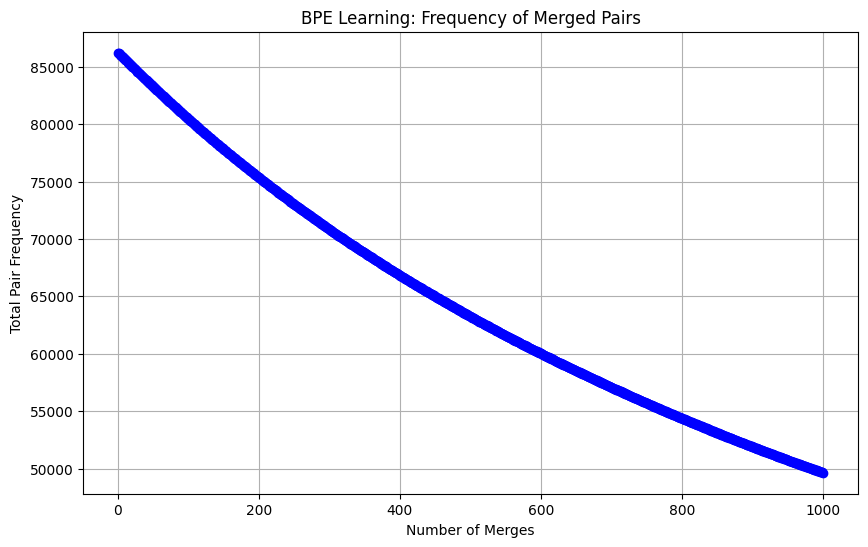

In [301]:
# Visualize BPE learning
visualize_bpe_learning(bpe)